Modele final: prediction utilisant Designation et Descriptions Camemeber + VIT

In [5]:
import os

import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Adagrad
import numpy as np
import ast

In [2]:

# PARAMS  de base
PATH = "images/crop224/"
img_size = 224
depth = 3

from RktnChallenge.RktnModel import ModelTrainer

trainer = ModelTrainer("embeddings_final.csv",PATH)



In [3]:

list_tags = trainer.data.prdtypecode.unique().tolist()
num_categories = len(list_tags)





X_data = trainer.data[["embeddings_desi","embeddings_desc","embedding_vit","designation_length_normalized","description_length_normalized","embeddings_desi_Flaubert",'prdtypecode']]

def convert_string_to_nparray(s):    
    # Supprime les caractères non désirés et divise la chaîne en une liste de nombres
    numbers = [float(x) for x in s.replace("[", "").replace("]", "").split()]
    return np.array(numbers)
def translate_string_to_array(s):
    liste_python = ast.literal_eval(s)
    return np.array(liste_python)

X_data.loc[:, 'embeddings_desc'] = X_data['embeddings_desc'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi'] = X_data['embeddings_desi'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi_Flaubert'] = X_data['embeddings_desi_Flaubert'].apply(convert_string_to_nparray)


X_data.loc[:, 'embedding_vit'] = X_data['embedding_vit'].apply(translate_string_to_array)

y = trainer.encodeLabel("prdtypecode")
label_size = trainer.getLabelSize()


In [4]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)

X1_train = X_train["embeddings_desi"].values
X1_train = np.stack(X1_train).astype(np.float32)
X2_train = X_train["embeddings_desc"].values
X2_train = np.stack(X2_train).astype(np.float32)
X3_train = X_train["embedding_vit"].values
X3_train = np.stack(X3_train).astype(np.float32)
X4_train = X_train["designation_length_normalized"].values
X5_train = X_train["description_length_normalized"].values
X6_train = X_train["embeddings_desi_Flaubert"].values
X6_train = np.stack(X6_train).astype(np.float32)





X1_test = X_test["embeddings_desi"].values
X1_test = np.stack(X1_test).astype(np.float32)
X2_test = X_test["embeddings_desc"].values
X2_test = np.stack(X2_test).astype(np.float32)
X3_test = X_test["embedding_vit"].values
X3_test = np.stack(X3_test).astype(np.float32)
X4_test = X_test["designation_length_normalized"].values
X5_test = X_test["description_length_normalized"].values
X6_test = X_test["embeddings_desi_Flaubert"].values
X6_test = np.stack(X6_test).astype(np.float32)

X_test.to_pickle('data_test.pkl')
X_test.to_parquet('data.parquet', compression='snappy')
#del X_data
#del X_test
#del X_train

In [18]:
print(X_test["prdtypecode"].values)


[2905 1281 2060 ... 2585 2522 1920]


In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_weighted(true, pred):  
    # Classes
    classes = K.arange(0, 27) 
    true = K.one_hot(K.cast(true, 'int32'), 27)
    
    # Calcule les TP, FP, FN pour chaque classe
    tp = K.dot(K.transpose(true), K.round(pred))
    fp = K.dot(K.transpose(1-true), K.round(pred))
    fn = K.dot(K.transpose(true), 1-K.round(pred))

    # Calcule le score F1 pour chaque classe
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())

    
    weighted_f1 = K.sum(f1 * K.sum(true, axis=0) / K.sum(true))
    return weighted_f1


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout,BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW,RMSprop
from tensorflow.keras.regularizers import l2

input_1 = Input(shape=(768,), name="Designation_Camembert_Embeddings")
input_2 = Input(shape=(768,), name="Descritption_Camembert_Embeddings")
input_3 = Input(shape=(768,), name="Images_VIT_Embeddings")
input_4 = Input(shape=(1,), name="Designation_Length_Normalized")
input_5 = Input(shape=(1,), name="Description_Length_Normalized")
input_6 = Input(shape=(768,), name="Designation_Flaubert_Embeddings")


# Concaténer les deux entrées
merged = Concatenate(axis=1)([input_1, input_2,input_3, input_4,input_5,input_6])

x = Dense(768, activation='relu')(merged)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)

output = Dense(27, activation='softmax')(x)


optimizer = AdamW(weight_decay=1e-5, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0)

model = Model(inputs=[input_1, input_2,input_3,input_4,input_5,input_6], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_weighted])

#'sparse_categorical_crossentropy'
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Designation_Camembert_Embe  [(None, 768)]                0         []                            
 ddings (InputLayer)                                                                              
                                                                                                  
 Descritption_Camembert_Emb  [(None, 768)]                0         []                            
 eddings (InputLayer)                                                                             
                                                                                                  
 Images_VIT_Embeddings (Inp  [(None, 768)]                0         []                            
 utLayer)                                                                                   

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda,Multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import AdamW

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")


# Le merge des  towers
# Poids pour la moyenne pondérée
w_i1 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable
w_i2 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i3 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i4 = tf.Variable(initial_value=tf.zeros([768]), trainable=True, dtype=tf.float32)

# Fusion moyenne pondérée
moyenne = Lambda(lambda features: w_i1 * features[0] + w_i2 * features[1] + w_i3*features[2]+w_i4)([input_1, input_2, input_3])

#produit = Multiply()([input_1, input_2])
#difference = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([input_1, input_2])


#merged = Concatenate(axis=1)([input_1, input_2])

x = Dense(512, activation='relu')(moyenne)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]',       

In [17]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,)

for h in range(0,2):
    i=0
    for train_index, val_index in kfold.split(np.zeros(len(y_train)), y_train):
        
        X1_train_fold, X1_val_fold = X1_train[train_index], X1_train[val_index]
        X2_train_fold, X2_val_fold = X2_train[train_index], X2_train[val_index]
        X3_train_fold, X3_val_fold = X3_train[train_index], X3_train[val_index]
        X4_train_fold, X4_val_fold = X4_train[train_index], X4_train[val_index]
        X5_train_fold, X5_val_fold = X5_train[train_index], X5_train[val_index]
        X6_train_fold, X6_val_fold = X6_train[train_index], X6_train[val_index]
        
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        if(i==0):
            patience = 6 #6
        else:
            patience = 4 #4
        early_stopper = tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy', mode='auto', patience=patience, 
                verbose=1, restore_best_weights=True
            ) 
        i+=1
        model.fit([X1_train_fold, X2_train_fold, X3_train_fold, X4_train_fold, X5_train_fold, X6_train_fold], y_train_fold, epochs=30, batch_size=32, validation_data=([X1_val_fold, X2_val_fold,X3_val_fold,X4_val_fold,X5_val_fold,X6_val_fold], y_val_fold),callbacks=[early_stopper])

Epoch 1/30
   3/1911 [..............................] - ETA: 1:20 - loss: 0.0013 - accuracy: 1.0000 - f1_weighted: 1.0000    

2023-10-04 05:00:03.137685: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



 152/1911 [=>............................] - ETA: 1:09 - loss: 0.0238 - accuracy: 0.9918 - f1_weighted: 0.9954

KeyboardInterrupt: 

 29/531 [>.............................] - ETA: 2s

2023-10-04 05:00:38.367010: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 3s 6ms/step
weighted F1 score: 0.905963635681653


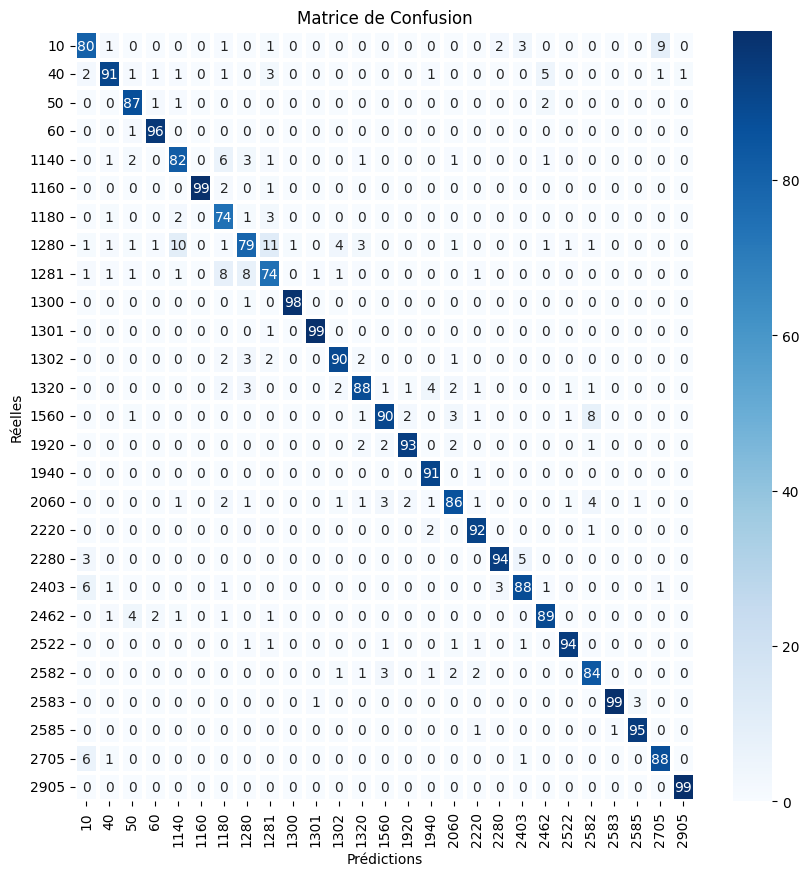

/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test,X6_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

model.save("final_model_kfold.h5")

 65/531 [==>...........................] - ETA: 1s

2023-09-27 22:00:01.162343: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.9070935814957617


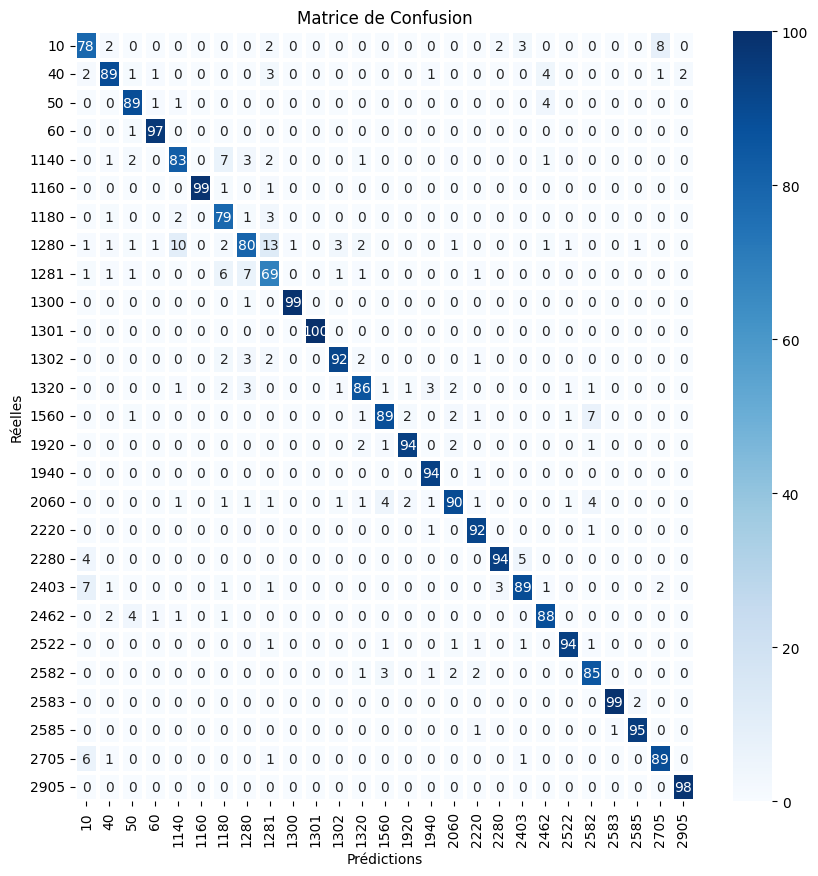

In [40]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test,X6_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

In [ ]:
early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        ) 

model.fit([X1_train, X2_train, X3_train], y_train, epochs=10, batch_size=10, validation_data=([X1_val, X2_val,X3_val], y_val),callbacks=[early_stopper])

Epoch 1/10
  26/5435 [..............................] - ETA: 34s - loss: 0.1079 - accuracy: 0.9654

2023-09-25 11:34:52.936126: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



5427/5435 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9845

2023-09-25 11:35:24.270413: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



5435/5435 [==============================] - 35s 6ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.2507 - val_accuracy: 0.9451
Epoch 2/10
5435/5435 [==============================] - 34s 6ms/step - loss: 0.0534 - accuracy: 0.9847 - val_loss: 0.2515 - val_accuracy: 0.9453
Epoch 3/10
5435/5435 [==============================] - 33s 6ms/step - loss: 0.0529 - accuracy: 0.9845 - val_loss: 0.2536 - val_accuracy: 0.9458
Epoch 4/10
5435/5435 [==============================] - 33s 6ms/step - loss: 0.0493 - accuracy: 0.9860 - val_loss: 0.2539 - val_accuracy: 0.9458
Epoch 5/10
5435/5435 [==============================] - 40s 7ms/step - loss: 0.0502 - accuracy: 0.9857 - val_loss: 0.2548 - val_accuracy: 0.9464
Epoch 6/10
5435/5435 [==============================] - 34s 6ms/step - loss: 0.0472 - accuracy: 0.9872 - val_loss: 0.2555 - val_accuracy: 0.9464
Epoch 7/10
5435/5435 [==============================] - 35s 6ms/step - loss: 0.0477 - accuracy: 0.9869 - val_loss: 0.2562 - val_accuracy: 0.9